In [1]:
#Makes jupyter notebook take up the width of the page
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [22]:
import numpy as np
from scipy.integrate import odeint
%matplotlib inline
import matplotlib.pyplot as plt
import math


#Basic gravitational acceleration equation
def acceleration(m, c1, c2):
        return (G*m*c1)/(c1**2+c2**2)**(3/2)


#Function which takes as input the equations of motion so that they can be input into the integrator 'odeint'
def arrayOfParameters(s, t):
        return [s[2], s[3], acceleration(M, -s[0], s[1]) + acceleration(m1, -2*s[0], -2*s[1]) + acceleration(m3, s[4]-s[0], s[5]-s[1]) + acceleration(m3, -s[4]-s[0], -s[5]-s[1]), 
                acceleration(M, -s[1], s[0]) + acceleration(m1, -2*s[1], -2*s[0]) + acceleration(m3, s[5]-s[1], s[4]-s[0]) + acceleration(m3, -s[5]-s[1], -s[4]-s[0]),

                s[6], s[7], acceleration(M, -s[4], s[5]) + acceleration(m3, -2*s[4], -2*s[5]) + acceleration(m1, s[0]-s[4], s[1]-s[5]) + acceleration(m1, -s[0]-s[4], -s[1]-s[5]), 
                acceleration(M, -s[5], s[4]) + acceleration(m3, -2*s[5], -2*s[4]) + acceleration(m1, s[1]-s[5], s[0]-s[4]) + acceleration(m1, -s[1]-s[5], -s[0]-s[4])]


#Basic model and plots of the system without any velocity correction
def initialModel(G,M,m1,m3,initialConditions,t):
    
    data = odeint(arrayOfParameters, initialConditions, t)#, rtol = 1.49012e-12, atol = 1.49012e-12, hmax = 0.001)

    x1 = data[:,0]
    y1 = data[:,1]
    x2 = -x1
    y2 = -y1
    x3 = data[:,4]
    y3 = data[:,5]
    x4 = -x3
    y4 = -y3

    plt.figure(figsize=(8,8))
    plt.plot(x1,y1, '-', label = 'm1', linewidth = 1)
    plt.plot(x2,y2,'-', label = 'm2', linewidth = 1)
    plt.plot(x3,y3, '-', label = 'm3', linewidth = 1)
    plt.plot(x4,y4,'-', label = 'm4', linewidth = 1)
    plt.legend()
    plt.xlabel("x Position (Dimensionless)")
    plt.ylabel("y Position (Dimensionless)")
    plt.axis("equal")
    plt.grid()
    plt.show()
    

#Algorithm which corrects the initial velocities so that the free oscillations are minimised
#(to only see the forced oscillations from the opposite bar)
def velocityCorrectorOld(vy1Init,vy3Init,initialConditions,percentage,iterations,output):
    
    vy1Guess, vy3Guess = vy1Init, vy3Init#1.0035*vy1Init, 0.97275*vy3Init 
    for i in range(iterations):
        vy1Range = np.linspace(vy1Guess - percentage*vy1Guess, vy1Guess + percentage*vy1Guess,5)
        vy3Range = np.linspace(vy3Guess - percentage*vy3Guess, vy3Guess + percentage*vy3Guess,5)
        standardDevs = np.full((len(vy1Range)*len(vy3Range), 2),np.inf)
        
        velocsMin = np.full((1, 2),np.inf)
        minDev = np.inf
        gridX , gridY = np.meshgrid(vy1Range, vy3Range)
        vy1Counter, vy3Counter = -1, -1
        for vy1 in vy1Range:
            initialConditions[3] = vy1
            vy1Counter += 1
            for vy3 in vy3Range:
                initialConditions[7] = vy3
                vy3Counter += 1

                data = odeint(arrayOfParameters,initialConditions,t)
                x1 = data[:,0]
                y1 = data[:,1]
                x3 = data[:,4]
                y3 = data[:,5]
                r1 = np.sqrt(x1**2+y1**2)
                r3 = np.sqrt(x3**2+y3**2)
                
                spread = (np.max(r1)-np.min(r1))/(np.mean(r1)) + (np.max(r3)-np.min(r3))/(np.mean(r3))
                if spread < minDev:
                    velocsMin[0][0], velocsMin[0][1] = vy1, vy3
                    minDev = spread

        
        
        if output == 1:
            print("Range of vy1 Values",vy1Range),print("Range of vy3 Values",vy3Range)
            print("vy1 and vy3 to minimise deviation of BOTH Bars",velocsMin)
            plt.scatter(gridX, gridY)
            plt.scatter(velocsMin[0][0], velocsMin[0][1], label = "Minimisation of both INNER and OUTER Bars")
            plt.xticks(vy1Range)
            plt.yticks(vy3Range)
            plt.xlabel("y Velocity Inner Bar")
            plt.ylabel("y Velocity Outer Bar")
            plt.xlim(gridX[0][0] - 0.0001*gridX[0][0], gridX[4][4] + 0.0001*gridX[4][4])
            plt.ylim(gridY[0][0] - 0.0001*gridY[0][0], gridY[4][4] + 0.0001*gridY[4][4])
            plt.axis("auto")
            plt.grid()
            plt.show()
        vy1Guess, vy3Guess = velocsMin[0][0], velocsMin[0][1]
        percentage = percentage/2
        print(i+1, end="  ")
    return velocsMin


#Function which returns the radii and angular veloc plots (used in the results) for the currently studied system
#Uses data found in the previous veloc correction function
#Also outputs the amplitudes of the plots for ease of input into the amplitude tables in results of report
def graphs(initialConditions, bigPlot):
    
    initialConditionsOrig = initialConditionsNew = [x1Init, y1Init, vx1Init, vy1Init, x3Init, y3Init, vx3Init, vy3Init]
    dataOrig = odeint(arrayOfParameters,initialConditionsOrig,t)
    x1orig = dataOrig[:,0]
    y1orig = dataOrig[:,1]
    x3orig = dataOrig[:,4]
    y3orig = dataOrig[:,5]

    initialConditionsNew[3], initialConditionsNew[7] = velocsMin[0][0], velocsMin[0][1]
    dataNew = odeint(arrayOfParameters,initialConditionsNew,t)#, rtol = 1.49012e-12, atol = 1.49012e-12)#, hmax = 0.001)
    x1New = dataNew[:,0]
    y1New = dataNew[:,1]
    x3New = dataNew[:,4]
    y3New = dataNew[:,5]
    x2New, y2New, x4New, y4New = -x1New, -y1New, -x3New, -y3New
    
    if bigPlot == 1:
    
        plt.figure(figsize=(8,8))
        plt.plot(x1New,y1New, '-', label = 'm1', linewidth = 1)
        plt.plot(x2New,y2New,'-', label = 'm2', linewidth = 1)
        plt.plot(x3New,y3New, '-', label = 'm3', linewidth = 1)
        plt.plot(x4New,y4New,'-', label = 'm4', linewidth = 1)
        plt.legend()
        plt.xlabel("x Position (Dimensionless)")
        plt.ylabel("y Position (Dimensionless)")
        plt.axis("equal")
        plt.grid()
        plt.show()
    
    angle1orig, angle3orig, angle1, angle3 = [], [], [], []

    for n in range(len(t)):
        angle1orig.append(math.atan2(y1orig[n],x1orig[n]))
        angle3orig.append(math.atan2(y3orig[n],x3orig[n]))
        angle1.append(math.atan2(y1New[n],x1New[n]))
        angle3.append(math.atan2(y3New[n],x3New[n]))

    radius1orig = np.sqrt(x1orig**2 + y1orig**2)
    radius3orig = np.sqrt(x3orig**2 + y3orig**2)
    radius1 = np.sqrt(x1New**2 + y1New**2)
    radius3 = np.sqrt(x3New**2 + y3New**2)
    
    ################################## ROTATING FRAMES ####################################
    vx1New = dataNew[:,2]
    vy1New = dataNew[:,3]
    vx3New = dataNew[:,6]
    vy3New = dataNew[:,7]

    angle1, angle3 = [], []
    for n in range(len(t)):
        angle1.append(math.atan2(y1New[n],x1New[n]))
        angle3.append(math.atan2(y3New[n],x3New[n]))

    #outer bar fixed to x axis - inner bar studied

    x1prime, vx1prime = x1New*np.cos(angle3) + y1New*np.sin(angle3), vx1New*np.cos(angle3) + vy1New*np.sin(angle3)
    y1prime, vy1prime = -x1New*np.sin(angle3) + y1New*np.cos(angle3), -vx1New*np.sin(angle3) + vy1New*np.cos(angle3)

    #inner bar fixed to x axis - outer bar studied

    x3prime, vx3prime = x3New*np.cos(angle1) + y3New*np.sin(angle1), vx3New*np.cos(angle1) + vy3New*np.sin(angle1)
    y3prime, vy3prime = -x3New*np.sin(angle1) + y3New*np.cos(angle1), -vx3New*np.sin(angle1) + vy3New*np.cos(angle1)

    counter1, counter3, oldAngle1, oldAngle3 = 0,0,0,0
    angle1prime, angle3prime, angle1primeMod, angle3primeMod, angle1Rest, angle3Rest = [], [], [], [], [], []
    for n in range(len(t)):

        angle1prime.append(math.atan2(y1prime[n],x1prime[n]) + counter1*2*np.pi) #/1
        angle3prime.append(-math.atan2(y3prime[n],x3prime[n]) + counter3*2*np.pi)

        if angle1prime[n] < oldAngle1:

            angle1prime[n] += 2*np.pi
            counter1 +=1
        if angle3prime[n] < oldAngle3:

            angle3prime[n] += 2*np.pi
            counter3 +=1
        oldAngle1 = angle1prime[n]
        oldAngle3 = angle3prime[n]
        angle1primeMod.append(math.atan2(y1prime[n],x1prime[n]))
        angle3primeMod.append(math.atan2(y3prime[n],x3prime[n]))
        
    counter1, counter3, oldAngle1, oldAngle3 = 0,0,0,0
    angle1Rest, angle3Rest = [], []
    for n in range(len(t)):

        angle1Rest.append(math.atan2(y1New[n],x1New[n]) + counter1*2*np.pi)
        angle3Rest.append(math.atan2(y3New[n],x3New[n]) + counter3*2*np.pi)

        if angle1Rest[n] < oldAngle1:

            angle1Rest[n] += 2*np.pi
            counter1 +=1
        if angle3Rest[n] < oldAngle3:

            angle3Rest[n] += 2*np.pi
            counter3 +=1
        oldAngle1 = angle1Rest[n]
        oldAngle3 = angle3Rest[n]
        
    vSquaredRest1 = np.sqrt(vx1New**2 + vy1New**2)
    vSquaredRest3 = np.sqrt(vx3New**2 + vy3New**2)
    angularVelocsRest1, angularVelocsRest3 = vSquaredRest1/radius1, vSquaredRest3/radius3
        
    radius1prime = np.sqrt(x1prime**2 + y1prime**2)
    radius3prime = np.sqrt(x3prime**2 + y3prime**2)
    vSquaredPrime1 = np.sqrt(vx1prime**2 + vy1prime**2)
    vSquaredPrime3 = np.sqrt(vx3prime**2 + vy3prime**2)
    angularVelocsPrime1, angularVelocsPrime3 = vSquaredPrime1/radius1prime,  vSquaredPrime3/radius3prime
    angularVelocsPrime1in3, angularVelocsPrime3in1 = angularVelocsPrime1 - angularVelocsPrime3, angularVelocsPrime3 - angularVelocsPrime1 #SWAPPED 1 AND 3 NUM ROUND. SHOULD I????
    
    minRad1, maxRad1, minRad3, maxRad3 = min(radius1prime), max(radius1prime), min(radius3prime), max(radius3prime)
    
    print("{:e}".format(max(radius1prime)-min(radius1prime)))
    print("{:e}".format(max(radius3prime)-min(radius3prime)))
    print("{:e}".format(max(angularVelocsRest1)-min(angularVelocsRest1)))
    print("{:e}".format(max(angularVelocsRest3)-min(angularVelocsRest3)))
    
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(14, 9))
    axes[0][0].ticklabel_format(useOffset=False)
    axes[0][1].ticklabel_format(useOffset=False)
    axes[1][0].ticklabel_format(useOffset=False)
    axes[1][1].ticklabel_format(useOffset=False)
    
    axes[0][0].scatter(angle1primeMod, radius1prime, s = 0.01)
    axes[1][0].scatter(angle3primeMod, radius3prime, s = 0.01)
    axes[0][1].scatter(angle1primeMod, angularVelocsRest1, s = 0.01, color = 'red')
    axes[1][1].scatter(angle3primeMod, angularVelocsRest3, s = 0.01, color = 'red')
    
    axes[0][0].title.set_text('Radius vs Angle of the Inner Bar in the Outer Bar Frame')
    axes[1][0].title.set_text('Radius vs Angle of the Outer Bar in the Inner Bar Frame')
    axes[0][1].title.set_text('Angular Velocity vs Angle of the Inner Bar in the Outer Bar Frame')
    axes[1][1].title.set_text('Angular Velocity vs Angle of the Outer Bar in the Inner Bar Frame')

    axes[0][0].set(xlabel="Angle (rad)", ylabel="Radius (Dimensionless)")
    axes[1][0].set(xlabel="Angle (rad)", ylabel="Radius (Dimensionless)")
    axes[0][1].set(xlabel="Angle (rad)", ylabel="Angular Velocity (Dimensionless)")
    axes[1][1].set(xlabel="Angle (rad)", ylabel="Angular Velocity (Dimensionless)")
    
    axes[0][0].set_ylim([min(radius1prime), max(radius1prime)])
    axes[1][0].set_ylim([min(radius3prime), max(radius3prime)])
    axes[0][1].set_ylim([min(angularVelocsRest1), max(angularVelocsRest1)])
    axes[1][1].set_ylim([min(angularVelocsRest3), max(angularVelocsRest3)])
    for row in axes: 
        for ax in row: 
            ax.grid(b=True, which='major', color='#666666', linestyle='-')
            ax.minorticks_on()  
            ax.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)  
    fig.tight_layout()
    name = str("project final results/M =" + str(M) + ",m1 = "+str(m1)+",m3 = "+str(m3)+",x1 = "+str(x1Init)+",x3 = "+str(x3Init) +'.png')
    print(name)
    plt.savefig(name)
    plt.show()
    return #angle1Rest, angularVelocsRest1, angle3Rest, angularVelocsRest3, angle1, angle3,angle1primeMod,angle3primeMod

In [17]:
#Parameters input into the system (masses, lengths, time etc.) in preperation to run the model and get the results

G = 1    #6.67e-11 #
M = 5     #5#0.1#15#0.01 #20, 10, 5, 1, 0.5, 0.05, 0.001, 0.00001
m1 = 2     #0.2#2#2#0.01/2#0.5 #2, 1, 0.5, 0.05  #m1 = m2 #USE THESE 1, 0.5, 0.1, 0.01
m3 = 1     #1.35 #m3 = m4

x1Init = 1
y1Init = 0
vx1Init = 0

x3Init = 2.875     #2.8575 #7
y3Init = 0
vx3Init = 0

vy1Init = np.sqrt(x1Init*(G*M/x1Init**2   +   G*m1/(2*x1Init)**2   +   G*m3/(x1Init+x3Init)**2   -   G*m3/(x3Init-x1Init)**2))  #1.00035  #1.0003
vy3Init = np.sqrt(x3Init*(G*M/x3Init**2   +   G*m3/(2*x3Init)**2   +   G*m1/(x3Init-x1Init)**2   +   G*m1/(x3Init-x1Init)**2))
print(vy1Init, vy3Init)

initialConditions = [x1Init, y1Init, vx1Init, vy1Init, x3Init, y3Init, vx3Init, vy3Init]
t = np.linspace(0,10,50000)     #50

2.298293464734316 2.2576975146446987


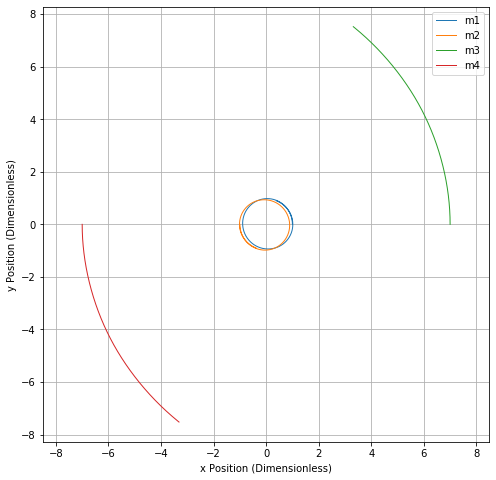

In [20]:
#Plot of initial system with parameters, without correcting the velocities
initialModel(G,M,m1,m3,initialConditions,t)

In [18]:
#Function ran which corrects the initial velocities in order to get more desirable orbits
velocsMin = velocityCorrectorOld(vy1Init,vy3Init,initialConditions,percentage = 0.2,iterations = 25,output = 0) #output 0 or 1 for correction graphs #0.2

1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  

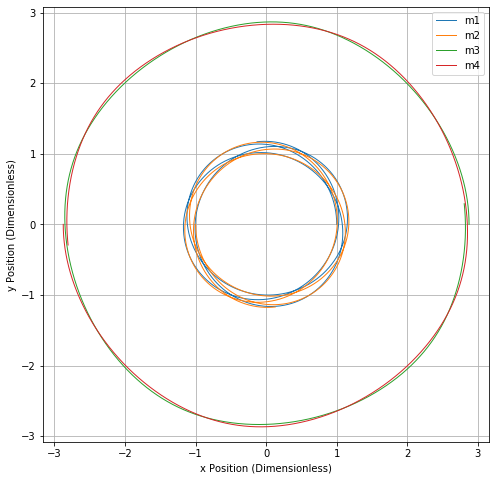

1.773526e-01
5.337518e-02
7.688105e-01
4.987221e-02
project final results/M =5,m1 = 2,m3 = 1,x1 = 1,x3 = 2.875.png


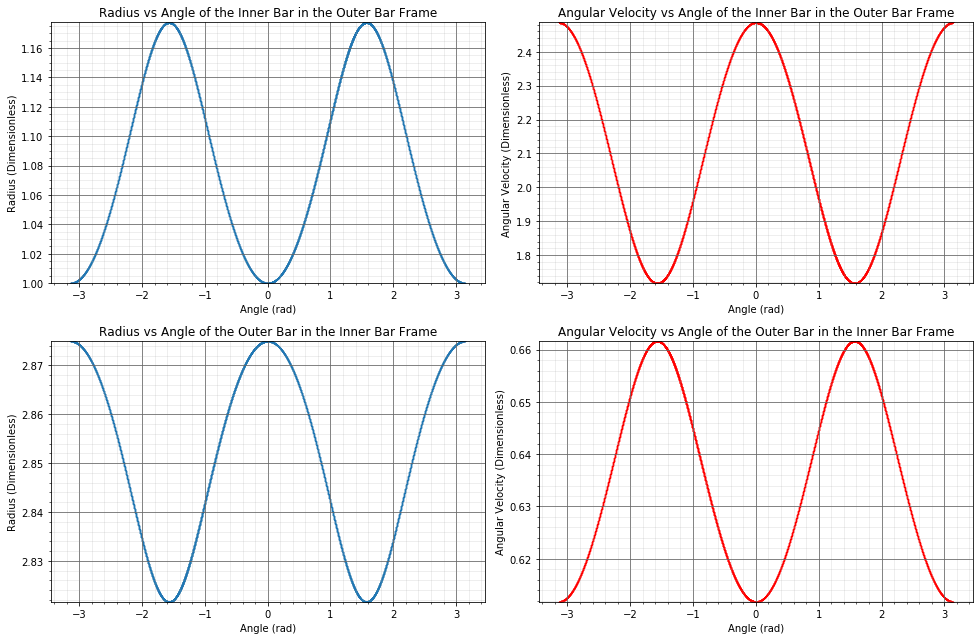

In [23]:
#Final results output (radii and angular velocs) to be put into the report
#Oscillation amplitudes also given
graphs(initialConditions, bigPlot = 1)

In [80]:
#Experimental code which aimed to improve the velocity correction and look at more unstable models
#Was unsuccessful (couldn't get it to work)

rad1Close0, rad3Close0, rad1ClosePi, rad3ClosePi = [],[],[],[]
e = np.pi/12

for phi in range(len(t)):
                    
    if abs(angle1[phi]) < e:
        rad1Close0.append(radius1[phi])
    
    if np.pi - e < angle1[phi] < np.pi or -np.pi < angle1[phi] < -np.pi + e:
        rad1ClosePi.append(radius1[phi])

    if abs(angle3[phi]) < e:
        rad3Close0.append(radius3[phi])
        
    if np.pi - e < angle3[phi] < np.pi or -np.pi < angle3[phi] < -np.pi + e:
        rad3ClosePi.append(radius3[phi])

diffRad1, diffRad3 = abs(np.mean(rad1Close0) - np.mean(rad1ClosePi)), abs(np.mean(rad3Close0) - np.mean(rad3ClosePi))
spread = abs(diffRad1 - diffRad3)

NameError: name 'radius1' is not defined

In [33]:
#Code which worked out the angular velocities through the derivative of rotation angle wrt time

from scipy import interpolate
tDeriv = t
f1 = interpolate.interp1d(tDeriv, angle1, fill_value='extrapolate')
f3 = interpolate.interp1d(tDeriv, angle3, fill_value='extrapolate')
#y = f1(tDeriv)

def deriv(f, t):
    h = 1e-5#5 #in theory h is an infinitesimal
    return (f(t+h)-f(t))/h
#tDeriv = np.delete(tDeriv, -1)

angularVelocc1 = deriv(y,tDeriv) 
angularVelocc3 = deriv(f3,tDeriv) 


plt.plot(angle1, angularVelocc1)
plt.show()
plt.plot(angle1, angularVelocc1 - angularVelocsRest1)
plt.show()


plt.plot(angle3, angularVelocc3)
plt.show()
plt.plot(angle3, angularVelocsRest3)
plt.show()
plt.plot(angle3, angularVelocc3 - angularVelocsRest3)
plt.show()

50000


TypeError: 'numpy.ndarray' object is not callable

In [10]:
#(Seperate model to the previous)
#Static model which was used to work out the theoretical mass ratios as a function of the torque
#Was used in the discussion i.e comparing/applying the previous models to real galaxies

import numpy as np
G = 1

def Fx(M,mTest,x,y,xTest,yTest):
    Fx = ((G*M*mTest)/((x-xTest)**2+(y-yTest)**2)**(3/2))*(x-xTest)
    return Fx

def Fy(M,mTest,x,y,xTest,yTest):
    Fy = ((G*M*mTest)/((x-xTest)**2+(y-yTest)**2)**(3/2))*(y-yTest)
    return Fy

def tangential(Fx,Fy,theta):
    fTangential = Fy*np.cos(theta) - Fx*np.sin(theta) 
    return fTangential

def radial(Fx,Fy,theta):
    fTangential = Fx*np.cos(theta) + Fy*np.sin(theta) 
    return fTangential

def angleBetween(x,y,xTest,yTest):
    angleBetween = np.arctan((y-yTest)/(x-xTest))
    return angleBetween

def torqueFinder(massRatio):

    G=1
    mTest,mBar= 0.01, 1
    mCentral = mBar*2*massRatio
    a = 1
    xTest,yTest = 0, a
    xCentral,yCentral = 0, 0
    x1,y1 = a*np.cos(np.pi/4), a*np.sin(np.pi/4)
    x2,y2 = -x1, -x1

    FxCentral, FyCentral = Fx(mCentral,mTest,xCentral,yCentral,xTest,yTest), Fy(mCentral,mTest,xCentral,yCentral,xTest,yTest)
    FxBar1, FyBar1 = Fx(mBar,mTest,x1,y1,xTest,yTest), Fy(mBar,mTest,x1,y1,xTest,yTest)
    FxBar2, FyBar2 = Fx(mBar,mTest,x2,y2,xTest,yTest), Fy(mBar,mTest,x2,y2,xTest,yTest)


    tangentialComponent = tangential(FxCentral, FyCentral, np.pi/2) + tangential(FxBar1, FyBar1, angleBetween(x1, y1, xTest, yTest)) + tangential(FxBar1, FyBar1, angleBetween(x2, y2, xTest, yTest))
    radialComponent = radial(FxCentral, FyCentral, np.pi/2) + radial(FxBar1, FyBar1, angleBetween(x1, y1, xTest, yTest)) + radial(FxBar1, FyBar1, angleBetween(x2, y2, xTest, yTest))

    torque = tangentialComponent/radialComponent

    print("Tangential; Radial; Torque (Tangential/Radial):",tangentialComponent,radialComponent,torque)

In [6]:
#Torque function ran. Given is the mass ratio, output is the torque
torqueFinder(2.5)

Tangential; Radial; Torque (Tangential/Radial): -0.017071067811865473 -0.03292893218813453 0.518421542318241
